In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import uproot

def read_root(file):
    file = uproot.open(file)
    tree = file[file.keys()[0]]
    dfH = pd.DataFrame(tree.arrays(library='np', how=tuple)).transpose()
    dfH.columns =tree.keys()
    file.close()
    return dfH

def gauss(x,m,sig):
    return np.exp(-(xx-m)*(xx-m)/(2.*sig*sig))/np.sqrt(2.*np.pi*sig*sig)

def get_sigma(df,sig):
    sig = np.std(df[np.abs(df)<3*sig])
    return np.std(df[np.abs(df)<2.5*sig])


In [1034]:
import numpy as np
import pandas as pd
import uproot

class ConvertToPixels:
    ChipSize = np.array([30., 15.]) # ALPIDE is a 30 mm x 15 mm chip
    PixelSize = np.array([0.02924,0.02688]) # pixelsize on ALPIDE
    # board contains 9 x 12 chips. The 12 chips are positioned in double layer 6-6 chips, with overlap overY \approx 0.1mm
    padX = 0.02912 # X padding: 29.12 micron
    Xgap = 0.1 # gap between ALPIDEs in X direction

    padY = 0.02944 # Y padding: 29.44 micron
    Ygap = 27.4 # distance between stripes in Y direction: 27.4 mm
    overY = 0.092 # overlap between F/B: 0.092 mm
    ElectrY = 1.208 # electronics part on the chip 1.208 mm
    Yshift = 0.85 # in Y direction the first chip starts at 0.85 mm (positive half)
    Ydif = 0.1 # for the negative half plane the first chip starts at 0.95 mm = 0.85 + Ydif
    
    ChipX = np.array([-ChipSize[0]/2+padX, ChipSize[0]/2-padX])
    ChipFY = np.array([Yshift + padY,Yshift + ChipSize[1] -ElectrY])
    YSize = (ChipFY[1] - ChipFY[0])/2. # 'radius' of the sensitive area (mm)
    ChipMidYF = (ChipFY[0]+ChipFY[1])/2
    ChipBY = np.array([Yshift + ChipSize[1] -ElectrY - overY + padY,Yshift + 2*ChipSize[1] -2*ElectrY - overY])
    ChipMidYB = (ChipBY[0]+ChipBY[1])/2.

    Xmin = 0
    Xmax = 1023
    Ymin = 0
    Ymax = 511
    
    Xmed = np.zeros(9) # middle of chip X positions, 9 chips 
    YmedF = np.zeros(6)
    YmedB = np.zeros(6)

    # cluster parameters (circleX, circleY Short_t circleX/Y[70])
    circleX = [0,1,0,-1,0,1,-1,-1,1,0,-2,0,2,1,-2,-1,2,-1,-2,1,2,-2,-2,2,2,0,-3,0,3,-1,-3,1,3,1,-3,-1,3,0,-4,0,4,2,-3,-2,3,-8,-2,-3,2,4,-1,-4,1,4,1,7,-1,3,3,-3,-3,4,2,-4,-2,4,-2,2,5,0];
    circleY = [0,0,-1,0,1,-1,-1,1,1,-2,0,2,0,-2,-1,2,1,-2,1,2,-1,-2,2,2,-2,-3,0,3,0,-3,1,3,-1,-3,-1,3,1,-4,0,4,0,-3,-2,3,2,15,-3,2,3,-1,-4,1,4,1,-4,-18,4,3,-3,-3,3,2,-4,-2,4,-2,-4,4,0,5];
    binPosLUT = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096]

    def __init__(self,CDIR):
        self.Xmed = np.linspace(-4.*(self.ChipSize[0]+self.Xgap),4.*(self.ChipSize[0]+self.Xgap),9)
        self.YmedF = np.array((-83.15+self.padY-83.15+self.ChipSize[1]-self.ElectrY)/2+np.arange(6)*27.4)
        self.YmedF[3:] += 2*self.Yshift+self.Ydif
        self.YmedB = self.YmedF + 27.4/2
        self.PosZ = np.concatenate([[225.219,225.219+52.4],333.369+5.5*np.arange(0.,48.,1.)])  # Z position of Layers
        
        file = uproot.open(CDIR+f'\\database_final_reduced.root')
        tree = file[file.keys()[0]]
        self.CSconfigs = pd.DataFrame(tree.arrays(library='np', how=tuple)).transpose()
        self.CSconfigs.columns =tree.keys()
        file.close()
        self.CSindex = pd.read_csv(CDIR+f'\\sortIndex.csv',sep=' ',header=0,names=['cs','start'])
        
        self.tol = 0.001 # tolerance of positioning layer to posZ

    
    def get_Pos(self,X,Y,Edep):
        res = np.empty((2,4),dtype=int); res.fill(-1)
        col = np.argmin(np.abs(X-self.Xmed)) # selects chip (column)
        pX = (X+self.ChipX[1]-self.Xmed[col])/self.PixelSize[0]
        iX = np.floor(pX) # should be between 0 and 1023 for valid hit

        df = pd.DataFrame(columns=['col','row','X','Y','edep'],dtype=float)
        if(iX >= self.Xmin and iX <= self.Xmax):
            row = np.argmin(np.abs(Y-self.YmedF)) # selects chip (column)
            pY = (self.YSize+(Y-self.YmedF[row]))/self.PixelSize[1]  
            iY = np.floor(pY)  # should be between 0 and 511 for valid hit
            if(iY >= self.Ymin and iY <= self.Ymax):
                df = df.append({'col': col, 'row': 2*row, 'X': pX, 'Y': pY, 'edep': Edep}, ignore_index=True)
            row = np.argmin(np.abs(Y-self.YmedB)) # selects chip (column)
            pY = (self.YSize+(Y-self.YmedB[row]))/self.PixelSize[1]
            iY = np.floor(pY)  # should be between 0 and 511 for valid hit
            if(iY >= self.Ymin and iY <= self.Ymax):
                df = df.append({'col': col, 'row': 2*row+1, 'X': pX, 'Y': pY, 'edep': Edep}, ignore_index=True)
        return df
    
    def get_Pos_multi(self,ps):  # receives a list of X,Y pairs
#        return np.vstack([y for y in [self.get_Pos(p[0],p[1]) for p in ps] if 0 not in y.shape])
        df = pd.DataFrame(columns=['col','row','X','Y','edep'],dtype=float)
        for p in ps:
            df = df.append(self.get_Pos(p[0],p[1],p[2]))
        return df

    def get_Coords(self,p):
        X = p[2]*self.PixelSize[0] + self.Xmed[p[0]] - self.ChipX[1]
        j = p[1] // 2; back = p[1] % 2
        Ymed = self.YmedF[j]
        if(back == 1):
            Ymed = self.YmedB[j]
        Y = Ymed - self.YSize + p[3]*self.PixelSize[1]
        return [X,Y]
    
    def set_CS_multi(self,ps): # ps is [pX,pY,Edep]
        df = pd.DataFrame(columns=['iX','iY'],dtype=int)
        for p in ps:
            CS = np.floor(4.2267 * (p[2]*40.)**0.65 + 0.5)
            if(CS < 2): # cluster sizes less than 1 are under threshold
                continue
            if(CS < 27):  # use library for shapes
                id = np.random.randint(self.CSindex['start'][CS-1],self.CSindex['start'][CS])
                x_mean = self.CSconfigs['x_mean'][id]
                y_mean = self.CSconfigs['y_mean'][id]
                CSarray = self.CSconfigs['hit_array'][id]
                for i in range(10):              
                    for j in range(10):
                        if(CSarray[i] & binPosLUT[j]):
                            outX = np.floor(p[0] + int(np.floor(i-x_mean+0.5)))
                            outY = np.floor(p[1] + int(np.floor(j-y_mean+0.5)))
                            if(outX >= self.Xmin and outX <= self.Xmax and outY >= self.Ymin and outY <= self.Ymax):
                                df=df.append({'iX': outX, 'iY': outY}, ignore_index=True)
                continue
            CS = int(min(CS,70))  # max cluster size is 70
            for i in range(CS):
                outX = np.floor(p[0] + self.circleX[i]+0.5)
                outY = np.floor(p[1] + self.circleY[i]+0.5)
                if(outX >= self.Xmin and outX <= self.Xmax and outY >= self.Ymin and outY <= self.Ymax):
                    df=df.append({'iX': outX, 'iY': outY}, ignore_index=True)
        return df
    
    def get_Layer(self,Zs):
        return [np.sum(z > self.PosZ - self.tol)-1 for z in Zs]
    
    def get_Layer_Pos(self):  # return the Z positions of Layers
        return self.PosZ
    
Cp = ConvertToPixels(f'C:\\Users\\Gábor\\Downloads\\pCT\\')
for X,Y,Edep in zip([45.02,213.6,37.4,37.4],[-14.6,34.7,23.5,186.3],[0.001,0.005,0.01,0.015]):
    print('({0:6.2f},{1:6.2f}) => '.format(X,Y), [[ [row['col'],row['row'],row['X'],row['Y']] for index,row in Cp.get_Pos(X,Y,Edep).iterrows()]])


( 45.02,-14.60) =>  [[[5.0, 4.0, 1022.259917920657, 510.43750000000034], [5.0, 5.0, 1022.259917920657, 0.7648809523813703]]]
(213.60, 34.70) =>  [[]]
( 37.40, 23.50) =>  [[[5.0, 7.0, 761.6580027359784, 331.8660714285721]]]
( 37.40,186.30) =>  [[]]


In [39]:
dfH = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\head_phantom_10000Primaries_230MeV_1617471898.root')
dfAm450 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile-450.root')
dfAm200 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile-200.root')
#dfAm50 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile-50.root')
dfA0 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile0.root')
dfA200 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile200.root')
#CSconfigs = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\database_final_reduced.root')
#CSindex = pd.read_csv(f'C:\\Users\\Gábor\\Downloads\\pCT\\sortIndex.csv',sep=' ',header=0,names=['cs','start'])
dfH['Layer'] = Cp.get_Layer(dfH['posZ'])

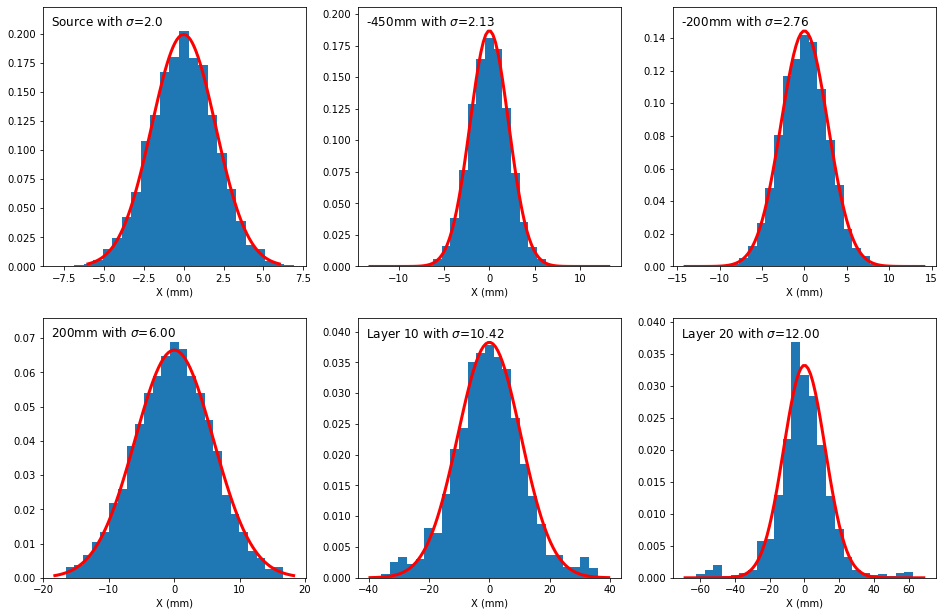

In [77]:
sh = 4
Layers = max(dfH['Layer'])
sigs = np.zeros(Layers+sh+1)

fig, ax = plt.subplots(2,3,figsize=(16,10.5))

sig = 2.
ttH = dfH[dfH['parentID']==0]
ax[0,0].hist(ttH['sourcePosX'],bins=25,density=True)
xx = np.linspace(-6,6,100)
yy = np.exp(-xx*xx/(2.*sig*sig))/np.sqrt(2.*np.pi*sig*sig)
ax[0,0].plot(xx,yy,'r',lw=3)
ax[0,0].text(0.03,0.97,r'Source with $\sigma$={}'.format(sig),horizontalalignment='left',verticalalignment='top',transform=ax[0,0].transAxes,fontsize=12)
ax[0,0].set_xlabel('X (mm)')
ax[0,0].set_ylim(0,1.05*ax[0,0].get_ylim()[1])
sigs[0] = sig

ii=1
for df,d in zip([dfAm450,dfAm200,dfA200],[-450,-200,200]):
    tt = df[df['ParentID']==0]
    i = ii // 3; j = ii % 3 
    ax[i,j].hist(tt['X'],bins=25,density=True,range=(-6*sig,6*sig))
    xx = np.linspace(ax[i,j].get_xlim()[0],ax[i,j].get_xlim()[1],100)
    sig = np.std(tt[np.abs(tt['X'])<ax[i,j].get_xlim()[1]]['X'])
    ax[i,j].plot(xx,gauss(xx,0.,sig),'r',lw=3)
    ax[i,j].text(0.03,0.97,r'{0}mm with $\sigma$={1:.2f}'.format(d,sig),horizontalalignment='left',verticalalignment='top',transform=ax[i,j].transAxes,fontsize=12)
    ax[i,j].set_xlabel('X (mm)')
    ax[i,j].set_ylim(0,1.05*ax[i,j].get_ylim()[1])
    sigs[ii] = sig
    ii += 1
    
for Layer in [10,20]:
    tt = dfH[(dfH['Layer']==Layer) & (dfH['primaryID']==1)]
    i = ii // 3; j = ii % 3 
    ax[i,j].hist(tt['posX'],bins=25,density=True,range=(-6*sig,6*sig))
    xx = np.linspace(ax[i,j].get_xlim()[0],ax[i,j].get_xlim()[1],100)
    sig = np.std(tt[np.abs(tt['posX'])<ax[i,j].get_xlim()[1]]['posX'])
    sig = np.std(tt[np.abs(tt['posX'])<2.5*sig]['posX'])
    ax[i,j].plot(xx,gauss(xx,0.,sig),'r',lw=3)
    ax[i,j].text(0.03,0.97,r'Layer {0} with $\sigma$={1:.2f}'.format(Layer,sig),horizontalalignment='left',verticalalignment='top',transform=ax[i,j].transAxes,fontsize=12)
    ax[i,j].set_xlabel('X (mm)')
    ax[i,j].set_ylim(0,1.05*ax[i,j].get_ylim()[1])
    ii += 1


In [1061]:
# spread of primaries only
ii = 4
for Layer in np.arange(Layers+1):
    sigs[ii] = get_sigma(dfH[(dfH['Layer']==Layer) & (dfH['parentID']==0)]['posX'],sigs[ii-1])
    ii += 1

In [103]:
# spread of ALL particles
sig = 2.
sigsAll = np.zeros(Layers+sh+1)
sigsAll[0] = get_sigma(dfH['sourcePosX'],sig) 

ii=1
for df in [dfAm450,dfAm200,dfA200]:
    sigsAll[ii] = get_sigma(df['X'],sigsAll[ii-1])
    ii += 1

for Layer in np.arange(Layers+1):
    sigsAll[ii] = get_sigma(dfH[(dfH['Layer']==Layer)]['posX'],sigsAll[ii-1])
    ii += 1

In [1056]:
# number of hits in the subsequent layers
NumHitsAll = [len(dfH[dfH['Layer']==L]['posX']) for L in range(50)]
NumHitsPrimary = [len(dfH[(dfH['Layer']==L) & (dfH['parentID']==0)]['posX']) for L in range(50)]

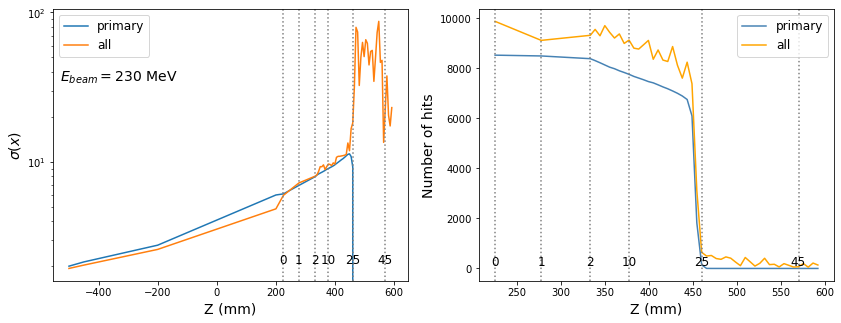

In [1062]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(np.concatenate([[-500,-450,-200,200],detPosZ]),sigs,label='primary')
ax[0].plot(np.concatenate([[-500,-450,-200,200],detPosZ]),sigsAll,label='all')
ax[0].set_xlabel('Z (mm)', fontsize=14)
ax[0].set_ylabel(r'$\sigma(x)$', fontsize=14)
ax[0].set_yscale('log')
ax[0].text(0.02,0.72,r'$E_{beam}=230$ MeV',horizontalalignment='left', verticalalignment='bottom', transform=ax[0].transAxes, fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(detPosZ,NumHitsPrimary,label='primary', color='steelblue')
ax[1].plot(detPosZ,NumHitsAll,label='all', color='orange')
ax[1].set_xlabel('Z (mm)', fontsize=14)
ax[1].set_ylabel('Number of hits', fontsize=14)
ax[1].legend(fontsize=12)

Layer_Pos = t.get_Layer_Pos()
for L in [0,1,2,10,25,45]:
    ax[0].axvline(x=Layer_Pos[L], ls='dotted', color='grey')
    ax[0].text(Layer_Pos[L],2,'{}'.format(L),horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax[1].axvline(x=Layer_Pos[L], ls='dotted', color='grey')
    ax[1].text(Layer_Pos[L],2,'{}'.format(L),horizontalalignment='center', verticalalignment='bottom', fontsize=12)


plt.show()

So in calorimetric layers the spread is already considerable ($\sigma\approx 10$ means that we are covering already $\approx$ two chips in $y$ extension and one chip in x extension), and in the "secondaries" region the spread is quite high ($\approx 60$mm), covering 6x12 chips (however, usually do not survive the clusterization)!

In [535]:
# get all the valid hits on ALPIDE with edep > 25 keV at Layer Layer
Layer = 10
EdepCut = 0.025 #MeV
tdf = dfH[(dfH['Layer']==Layer) & (dfH['edep'] > EdepCut)]
#Hits = [t.get_Pos(X,Y) for X,Y,edep in zip(tdf['posX'],tdf['posY'],tdf['edep']) if edep > 0.025]
##Hits = [t.get_Pos(X,Y) for X,Y in zip([45.02,213.6,37.4,37.4],[-14.72,34.7,23.5,186.3])]
#Hits = np.vstack([y for y in Hits if 0 not in y.shape])
Hits = Cp.get_Pos_multi(zip(tdf['posX'],tdf['posY']))

# transform back the real hits to the coordinate system
RHits = pd.DataFrame([Cp.get_Coords(p) for p in Hits],columns=['X','Y'])

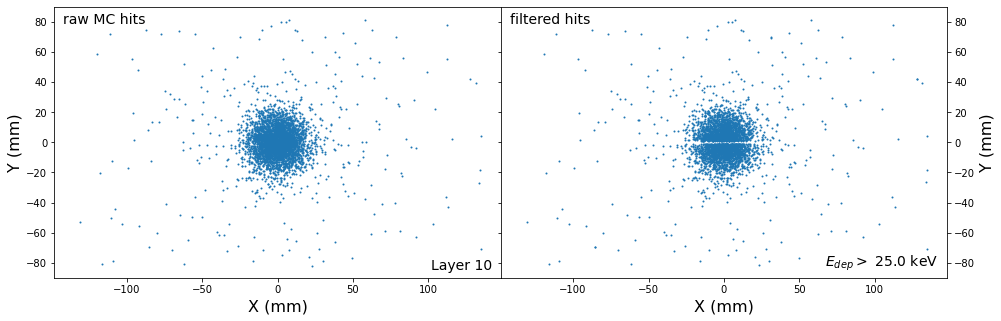

In [974]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5), sharey=True)
plt.subplots_adjust(wspace=0)

ax[0].scatter(tdf['posX'],tdf['posY'],s=1)
ax[0].set_xlabel('X (mm)', fontsize=16)
ax[0].set_ylabel('Y (mm)', fontsize=16)
ax[0].set_aspect(1)
ax[0].text(0.02,0.98,'raw MC hits',horizontalalignment='left',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(RHits['X'],RHits['Y'],s=1)
ax[1].set_xlabel('X (mm)', fontsize=16)
ax[1].set_ylabel('Y (mm)', fontsize=16)
ax[1].set_aspect(1)
ax[1].text(0.02,0.98,'filtered hits',horizontalalignment='left',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,r'$E_{{dep}} >$ {0} keV'.format(EdepCut*1000),horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)
ax[1].yaxis.set_label_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True, left=True, right=True)

xm = np.amax(np.abs(ax[0].get_xlim()+ax[1].get_xlim()))
ym = np.amax(np.abs(ax[0].get_ylim()+ax[1].get_ylim()))
ax[0].set_xlim(-xm,xm); ax[1].set_xlim(-xm,xm)
ax[0].set_ylim(-ym,ym); ax[1].set_ylim(-ym,ym)
plt.show()

In [851]:
chipX = 4
chipY = 6
#Layer = 10
#dfL10 = dfH[(dfH['Layer']==Layer)]
Ht = Cp.get_Pos_multi(zip(dfL10['posX'],dfL10['posY'],dfL10['edep']))
SHits46 = Ht[(Ht['col'] == 4) & (Ht['row'] == 6)]
SHits45 = Ht[(Ht['col'] == 4) & (Ht['row'] == 5)]
SHits56 = Ht[(Ht['col'] == 5) & (Ht['row'] == 6)]
SHits55 = Ht[(Ht['col'] == 5) & (Ht['row'] == 5)]

In [558]:
# old format (get_Pos was returning a 0,1 or 2 line array, now it is returning a dataframe) , thats a bit trickier to get now
Layer = 10
dfL10 = dfH[(dfH['Layer']==Layer)]
Ht = [t.get_Pos(X,Y) for X,Y,edep in zip(dfL10['posX'],dfL10['posY'],dfL10['edep'])]
tt0 = [y for y in Ht if y.shape[0] == 0]
tt1 = [y for y in Ht if y.shape[0] == 1]
tt2 = [y for y in Ht if y.shape[0] == 2]
print('in Layer {0} Single hit: {1:.2f}% ({2}), No hit: {3:.2f}% ({4}), Double hit: {5:.2f}% ({6})'.format(
    Layer,100.*len(tt1)/len(Ht),len(tt1),100.*len(tt0)/len(Ht),len(tt0),100.*len(tt2)/len(Ht),len(tt2)))

in Layer 10 Single hit: 92.68% (8461), No hit: 7.16% (654), Double hit: 0.15% (14)


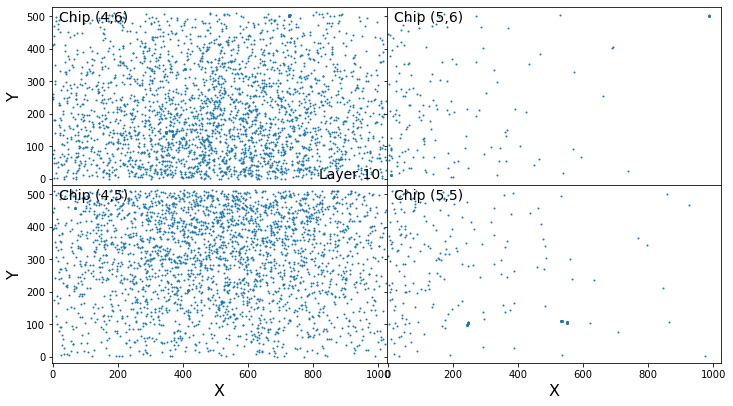

In [973]:
fig, ax = plt.subplots(2,2,figsize=(12,6.55),sharey=True, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

plt.xlim(-2,1025)
#plt.ylim(0,511)

ax[0,0].scatter(SHits46['X'],SHits46['Y'],s=1)
ax[0,0].set_aspect(1)
ax[0,0].set_ylabel('Y', fontsize=16)
ax[0,0].set_ylim(-18,529)
ax[0,0].text(0.02,0.98,'Chip ({0},{1})'.format(4,6),horizontalalignment='left',verticalalignment='top',transform=ax[0,0].transAxes,fontsize=14)
ax[0,0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0,0].transAxes,fontsize=14)

ax[0,1].scatter(SHits56['X'],SHits56['Y'],s=1)
ax[0,1].set_aspect(1)
ax[0,1].set_ylim(-18,529)
ax[0,1].text(0.02,0.98,'Chip ({0},{1})'.format(5,6),horizontalalignment='left',verticalalignment='top',transform=ax[0,1].transAxes,fontsize=14)

ax[1,0].scatter(SHits45['X'],SHits45['Y'],s=1)
ax[1,0].set_aspect(1)
ax[1,0].set_ylim(-18,529)
ax[1,0].set_xlabel('X', fontsize=16)
ax[1,0].set_ylabel('Y', fontsize=16)
ax[1,0].text(0.02,0.98,'Chip ({0},{1})'.format(4,5),horizontalalignment='left',verticalalignment='top',transform=ax[1,0].transAxes,fontsize=14)

ax[1,1].scatter(SHits55['X'],SHits55['Y'],s=1)
ax[1,1].set_aspect(1)
ax[1,1].set_ylim(-18,529)
ax[1,1].set_xlabel('X', fontsize=16)
ax[1,1].text(0.02,0.98,'Chip ({0},{1})'.format(5,5),horizontalalignment='left',verticalalignment='top',transform=ax[1,1].transAxes,fontsize=14)

plt.show()

In [931]:
HtCS46 = Cp.set_CS_multi(zip(SHits46['X'],SHits46['Y'],SHits46['edep']))
HtCS56 = Cp.set_CS_multi(zip(SHits56['X'],SHits56['Y'],SHits56['edep']))

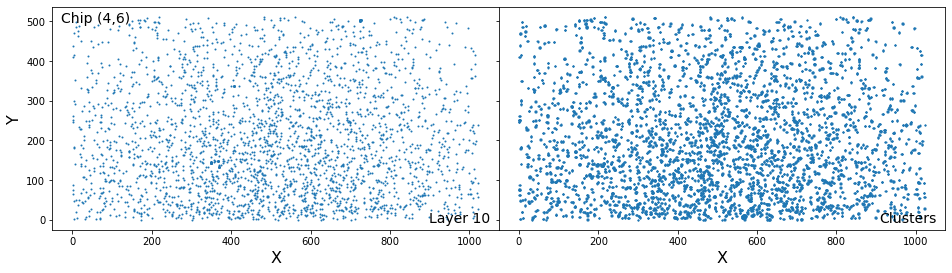

In [972]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
plt.subplots_adjust(wspace=0)

ax[0].scatter(SHits46['X'],SHits46['Y'],s=1)
ax[0].set_aspect(1)
ax[0].set_xlabel('X', fontsize=16)
ax[0].set_ylabel('Y', fontsize=16)
ax[0].text(0.02,0.98,'Chip ({0},{1})'.format(chipX,chipY),horizontalalignment='left',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(HtCS46['iX'],HtCS46['iY'],s=1)
ax[1].set_aspect(1)
ax[1].set_xlabel('X', fontsize=16)
#ax[1].text(0.02,0.98,'Chip ({0},{1})'.format(chipX,chipY),horizontalalignment='left',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,'Clusters',horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)

plt.show()

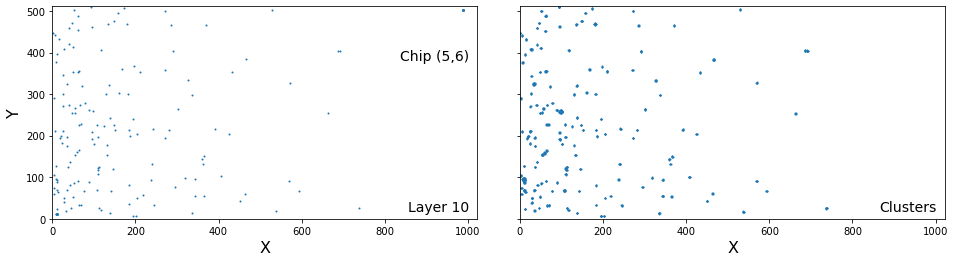

In [971]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
plt.subplots_adjust(wspace=0.1)

plt.xlim(0,1023)
plt.ylim(0,511)

ax[0].scatter(SHits56['X'],SHits56['Y'],s=1)
ax[0].set_aspect(1)
ax[0].set_xlim(0,1023)
ax[0].set_xlabel('X', fontsize=16)
ax[0].set_ylabel('Y', fontsize=16)
ax[0].text(0.98,0.8,'Chip ({0},{1})'.format(5,6),horizontalalignment='right',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(HtCS56['iX'],HtCS56['iY'],s=1)
ax[1].set_aspect(1)
ax[1].set_xlabel('X', fontsize=16)
#ax[1].text(0.98,0.98,'Chip ({0},{1})'.format(5,6),horizontalalignment='right',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,'Clusters',horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)

plt.show()

In [938]:
totCS46 = sum(t.get_CS(SHits46['edep']))
totCS56 = sum(t.get_CS(SHits56['edep']))
print('Cluster loss in chip (4,6): {0:.2f}%, in chip (5,6): {1:.2f}%'.format(100.*(1.-len(HtCS46)/totCS46),100.*(1.-len(HtCS56)/totCS56)))

Cluster loss in chip (4,6): 0.46%, in chip (5,6): 0.73%


In [1065]:
# Check layer 26
dfL26 = dfH[dfH['Layer']==26]
Ht26 = Cp.get_Pos_multi(zip(dfL26['posX'],dfL26['posY'],dfL26['edep']))
Ht26_46 = Ht26[(Ht26['col'] == 4) & (Ht26['row'] == 6)]
Ht26CS_46 = Cp.set_CS_multi(zip(Ht26_46['X'],Ht26_46['Y'],Ht26_46['edep']))
len(Ht26CS_46)
# IS ZERO !!!

In [966]:
cs_mean = np.zeros(50)
cs_std = np.zeros(50)
cs_all = 0
cs_28 = 0
for L in range(50):
    tt = t.get_CS(dfH[dfH['Layer']==L]['edep'])
    cs_mean[L] = np.mean(tt)
    cs_std[L] = np.std(tt)
    cs_all += sum(tt)
    if(Layer < 28):
        cs_28 += sum(tt)

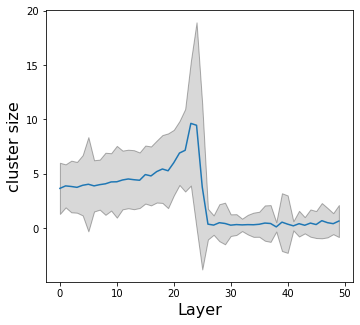

In [970]:
fig, ax = plt.subplots(figsize=(5.5,5))
ax.plot(range(50),cs_mean)
ax.fill_between(range(50),cs_mean-cs_std,cs_mean+cs_std,facecolor='gray',edgecolor='k',alpha=0.3)
ax.set_xlabel('Layer', fontsize=16)
ax.set_ylabel('cluster size', fontsize=16)
plt.show()

In [967]:
print('Average cluster size: {0:.2f} (all Layers), {1:.2f} (first 28 Layers)'.format(cs_all/len(dfH), cs_28/len(dfH[dfH['Layer']<28])))

Average cluster size: 4.74 (all Layers), 4.85 (first 28 Layers)


In [1035]:
# testing transformation to pixel coords and back
res = Cp.get_Pos(45.02,-14.6,0.03)
print(res)
for i in range(len(res)):
    print(Cp.get_Coords([int(res.iloc[i]['col']), int(res.iloc[i]['row']), res.iloc[i]['X'], res.iloc[i]['Y']]))

   col  row            X           Y  edep
0  5.0  4.0  1022.259918  510.437500  0.03
1  5.0  5.0  1022.259918    0.764881  0.03
[45.02, -14.600000000000001]
[45.02, -14.600000000000001]
